# Playing with Ohio's Covid-19 Data 
This is a small demonstration notebook showing how to do some graphical analysis using COVID-19 data that has been supplied by the State of Ohio.

## Goals:
1. To have some fun while physically distancing
2. Demonstrate some graphical analysis using Python, Pandas, and Matplotlib
3. Try to reproduce some of Ohio's COVID-19 Dashboard (https://coronavirus.ohio.gov/wps/portal/gov/covid-19/dashboards)

In [1]:
# Import the libararies that we will need
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
    
plt.style.use('fivethirtyeight')

# Read the data provided from the web.
df = pd.read_csv("https://coronavirus.ohio.gov/static/COVIDSummaryData.csv", low_memory=False)

In [2]:
# Read the data provided from the web.
df = pd.read_csv("https://coronavirus.ohio.gov/static/COVIDSummaryData.csv", low_memory=False)
df.columns

Index(['County', 'Sex', 'Age Range', 'Onset Date', 'Date Of Death',
       'Admission Date', 'Case Count', 'Death Due to Illness Count',
       'Hospitalized Count'],
      dtype='object')

In [3]:
# Drop Totals in last row
df = df.drop(df.index[df.shape[0]-1])

# Fix some type issues
# print(df["Case Count"].unique())
df["Case Count"] = pd.to_numeric(df["Case Count"])
df["Hospitalized Count"] = pd.to_numeric(df["Hospitalized Count"])
df["Death Count"] = pd.to_numeric(df["Death Due to Illness Count"])
df["Onset Date"] = pd.to_datetime(df["Onset Date"])

df['Date Of Death'] = df['Date Of Death'].replace(['Unknown'],'2020/03/01')

# print(df['Date Of Death'])
df["Date Of Death"] = pd.to_datetime(df["Date Of Death"])
# df.sort_values(by="Onset Date")

df['Admission Date'] = df['Admission Date'].replace(['Unknown'],'2020/03/01')
df["Admission Date"] = pd.to_datetime(df["Admission Date"])
# df["Onset Date"]

# Is there a reporting issue leading to more cases, deaths, and/or hospitalizations on weekends or weekdays?

In [4]:
df = df[df["County"] == "Wood"]
df = df.reset_index()

# Here we have the actual Case Rates

In [5]:
# Sum up the total Cases, Deaths, and Hospitalizations
TotalCases  = int(df[["Case Count"]].sum())
TotalDeaths = int(df[["Death Count"]].sum())
TotalHospitalization = int(df[["Hospitalized Count"]].sum())

# print(TotalDeaths)
# Print with some nice formatting
print("Total Cases:", "{0:,}".format(TotalCases))
print("Total Deaths:", "{0:,} ({1:.2f}%)".format(TotalDeaths, TotalDeaths/TotalCases*100))
print("Total Hospitalizations:", "{0:,} ({1:.2f}%)".format(TotalHospitalization, TotalHospitalization/TotalCases*100))

n = TotalCases-(TotalHospitalization+TotalDeaths)
print("Non Severe Cases:", "{0:,} ({1:.2f}%)".format(n, n/TotalCases*100))

Total Cases: 2,909
Total Deaths: 104 (3.58%)
Total Hospitalizations: 239 (8.22%)
Non Severe Cases: 2,566 (88.21%)


# Adjustments with multiplier

The CDC has calculated the actual IFR to be .64%. That means that TotalCases * IFR = TotalDeaths. In other words, we can calculate how many cases there should be by dividing TotalDeaths by the IFR

In [6]:
TotalActualCases = TotalDeaths/.0054 # https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html

print("Estimated Total Cases:", "{0:,}".format(TotalActualCases))
print("Total Deaths:", "{0:,} ({1:.2f}%)".format(TotalDeaths, TotalDeaths/TotalActualCases*100))
print("Total Hospitalizations:", "{0:,} ({1:.2f}%)".format(TotalHospitalization, TotalHospitalization/TotalActualCases*100))

n = TotalActualCases-(TotalHospitalization+TotalDeaths)
print("Non Severe Cases:", "{0:,} ({1:.2f}%)".format(n, n/TotalActualCases*100))
print("Likely updated on: ", df["Onset Date"].max())


Estimated Total Cases: 19,259.25925925926
Total Deaths: 104 (0.54%)
Total Hospitalizations: 239 (1.24%)
Non Severe Cases: 18,916.25925925926 (98.22%)
Likely updated on:  2020-11-03 00:00:00


In [7]:
# Various Groupings of Interest
dfAge     = df.groupby(["Age Range"])
dfDate    = df.groupby(["Onset Date"])
dfSex     = df.groupby(["Sex"])
dfCounty  = df.groupby(["County"])
dfAgeDate = df.groupby(["Age Range","Onset Date"])

dfDeathDate = df.groupby(["Date Of Death"])

dfCaseAgeDate = df.groupby(["Age Range","Onset Date"])
dfDeathAgeDate= df.groupby(["Age Range", "Date Of Death"])
dfHospAgeDate= df.groupby(["Age Range", "Admission Date"])

# Age Grouped Statistics

In [8]:
dfAgeTotals = pd.DataFrame()

# Totals by Age
dfAgeTotals["Deaths"]       = dfAge["Death Count"].sum()
dfAgeTotals["Hospitalized"] = dfAge["Hospitalized Count"].sum()
dfAgeTotals["Cases"]        = dfAge["Case Count"].sum()

# Percentages based on Overall Case Count
dfAgeTotals["DeathPerc"]        = dfAge["Death Count"].sum()/TotalCases*100
dfAgeTotals["HospitalizedPerc"] = dfAge["Hospitalized Count"].sum()/TotalCases*100
dfAgeTotals["CasesPerc"]        = dfAge["Case Count"].sum()/TotalCases*100

# Percentage of Age Group
dfAgeTotals["DeathPercAge"]        = dfAge["Death Count"].sum()/dfAge["Case Count"].sum()*100
dfAgeTotals["HospitalizedPercAge"] = dfAge["Hospitalized Count"].sum()/dfAge["Case Count"].sum()*100

dfAgeTotals["Non Severe Case %"] = 100-dfAgeTotals["DeathPercAge"]-dfAgeTotals["HospitalizedPercAge"]

# Include index as column for later use
dfAgeTotals["Age Range"] = dfAgeTotals.index
# dfAgeTotals

dfAgeTotalsStyled = dfAgeTotals.style.format({
    'Deaths': '{:,.0f}'.format,
    'Hospitalized': '{:,.0f}'.format,
    'Cases': '{:,.0f}'.format,
    'HospitalizedPerc': '{:,.2f} %'.format,
    'CasesPerc': '{:,.2f} %'.format,
    'DeathPerc': '{:,.2f} %'.format,
    'HospitalizedPercAge': '{:,.2f} %'.format,
    'DeathPercAge': '{:,.2f} %'.format,
    'Non Severe Case %': '{:,.2f} %'.format
})

dfAgeTotalsStyled

# print(dfAgeTotals["DeathPerc"].mean())

In [9]:
# dfAgeTotals = pd.DataFrame()

# dfAge = df[(df["Onset Date"] >= "2020-10-01") | (df["Admission Date"] >= "2020-10-01")  | (df["Date Of Death"] >= "2020-10-01")].groupby(["Age Range"])

# # Totals by Age
# dfAgeTotals["Deaths"]       = dfAge["Death Count"].sum()
# dfAgeTotals["Hospitalized"] = dfAge["Hospitalized Count"].sum()
# dfAgeTotals["Cases"]        = dfAge["Case Count"].sum()

# # Percentages based on Overall Case Count
# dfAgeTotals["DeathPerc"]        = dfAge["Death Count"].sum()/TotalCases*100
# dfAgeTotals["HospitalizedPerc"] = dfAge["Hospitalized Count"].sum()/TotalCases*100
# dfAgeTotals["CasesPerc"]        = dfAge["Case Count"].sum()/TotalCases*100

# # Percentage of Age Group
# dfAgeTotals["DeathPercAge"]        = dfAge["Death Count"].sum()/dfAge["Case Count"].sum()*100
# dfAgeTotals["HospitalizedPercAge"] = dfAge["Hospitalized Count"].sum()/dfAge["Case Count"].sum()*100

# dfAgeTotals["Non Severe Case %"] = 100-dfAgeTotals["DeathPercAge"]-dfAgeTotals["HospitalizedPercAge"]

# # Include index as column for later use
# dfAgeTotals["Age Range"] = dfAgeTotals.index
# # dfAgeTotals

# dfAgeTotalsStyled = dfAgeTotals.style.format({
#     'HospitalizedPerc': '{:,.2f} %'.format,
#     'CasesPerc': '{:,.2f} %'.format,
#     'DeathPerc': '{:,.2f} %'.format,
#     'HospitalizedPercAge': '{:,.2f} %'.format,
#     'DeathPercAge': '{:,.2f} %'.format,
#     'Non Severe Case %': '{:,.2f} %'.format
# })

# dfAgeTotalsStyled

# # print(dfAgeTotals["DeathPerc"].mean())

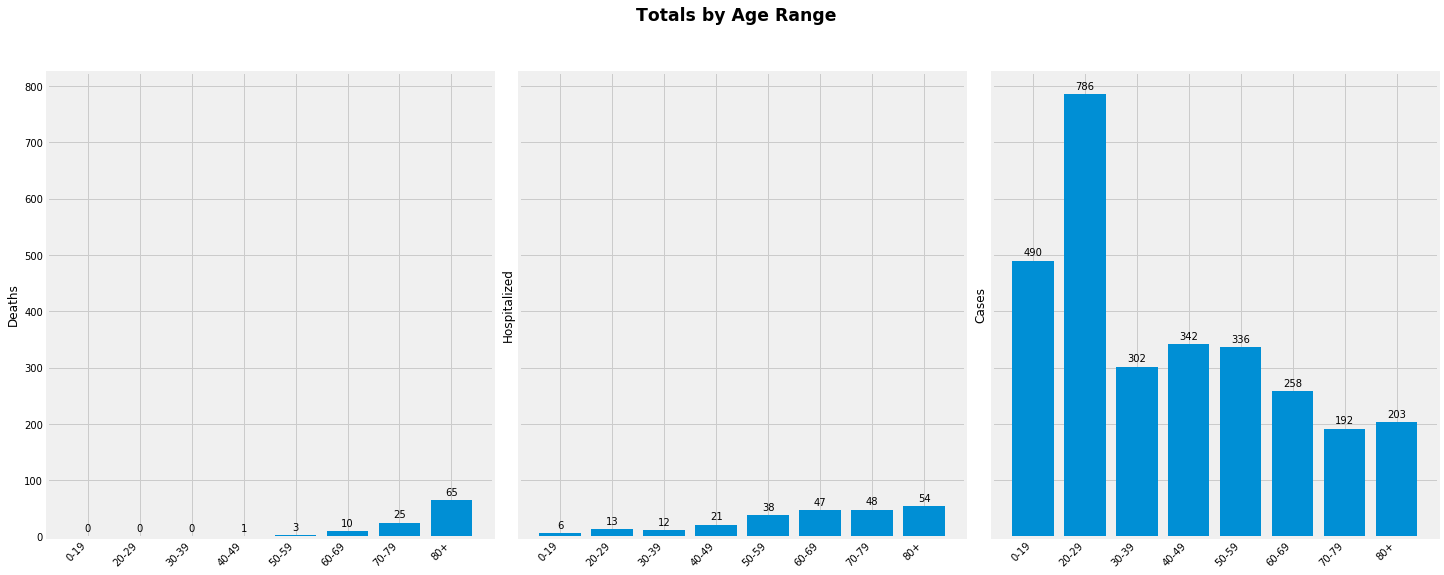

In [10]:
# Taken from the Matplotlib website, butmodified to include formatting
def autolabel(ax, rects, labelFormat="{:}", xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate(labelFormat.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')
        
        
# Create a new sbuplot with 1 row, 3 items
fig, ax = plt.subplots(1,3, sharey=True, figsize=(20,7))
fig.tight_layout()

# Plot, label, and format
r = ax[0].bar(dfAgeTotals["Age Range"], dfAgeTotals["Deaths"])
ax[0].set_ylabel('Deaths')
ax[0].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[0], r, labelFormat="{:,}")

r = ax[1].bar(dfAgeTotals["Age Range"], dfAgeTotals["Hospitalized"])
ax[1].set_ylabel('Hospitalized')
ax[1].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[1], r, labelFormat="{:,}")

r = ax[2].bar(dfAgeTotals["Age Range"], dfAgeTotals["Cases"])
ax[2].set_ylabel('Cases')
ax[2].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[2], r, labelFormat="{:,}")

fig.suptitle("Totals by Age Range", y=1.1, fontsize="xx-large", fontweight="bold")

plt.show()

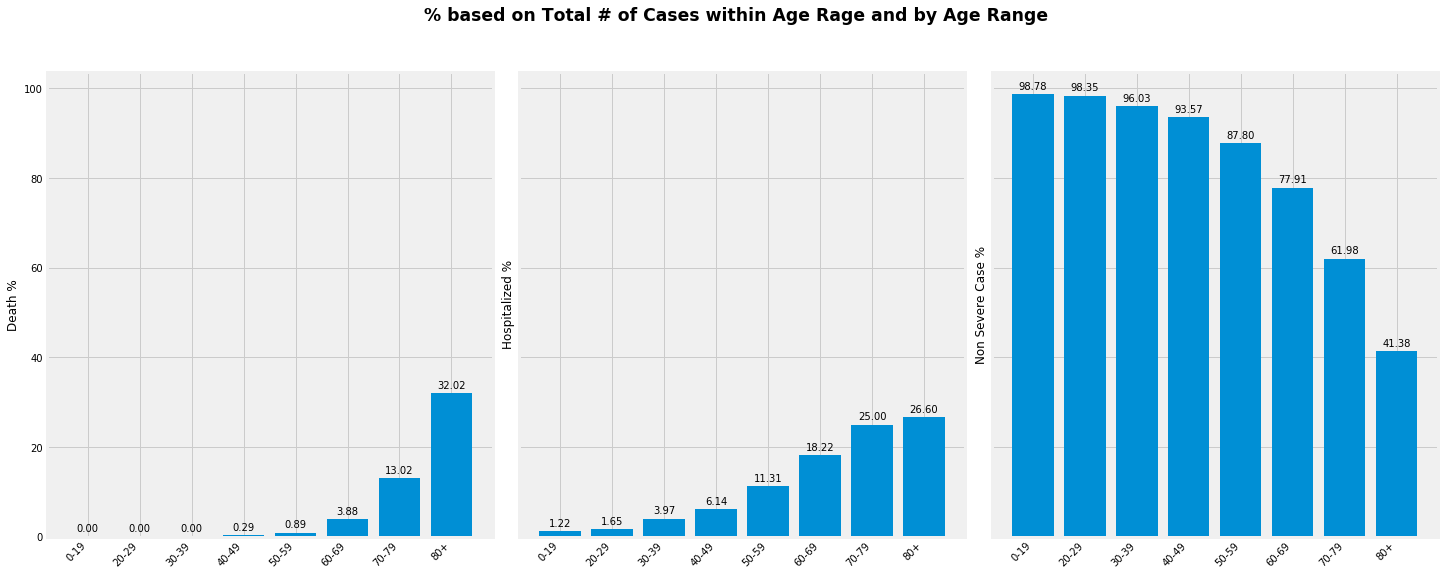

In [11]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(20,7))
fig.tight_layout()

r = ax[0].bar(dfAgeTotals["Age Range"], dfAgeTotals["DeathPercAge"])
ax[0].set_ylabel('Death %')
ax[0].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[0], r, labelFormat="{:.2f}")

r = ax[1].bar(dfAgeTotals["Age Range"], dfAgeTotals["HospitalizedPercAge"])
ax[1].set_ylabel('Hospitalized %')
ax[1].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[1], r, labelFormat="{:.2f}")

r = ax[2].bar(dfAgeTotals["Age Range"], dfAgeTotals["Non Severe Case %"])
ax[2].set_ylabel('Non Severe Case %')
ax[2].set_xticklabels(dfAgeTotals["Age Range"], rotation=45, ha='right')
autolabel(ax[2], r, labelFormat="{:.2f}")

fig.suptitle("% based on Total # of Cases within Age Rage and by Age Range", y=1.1, fontsize="xx-large", fontweight="bold")
plt.show()

/Users/greenr/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/greenr/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/greenr/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


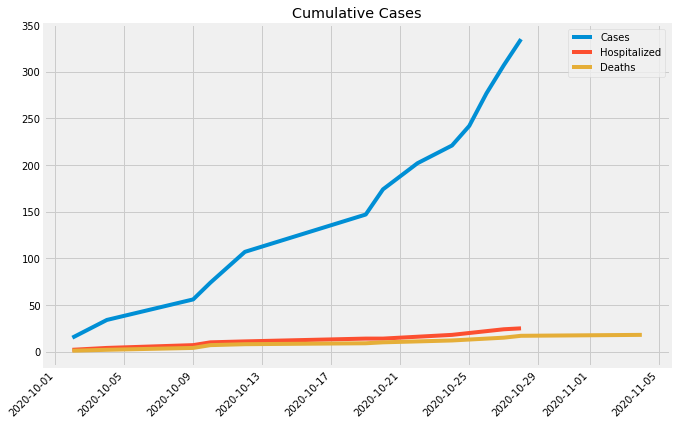

In [12]:
# By Date
dfTotals = pd.DataFrame()

dfTotals["Deaths"]       = dfDeathDate["Death Count"].sum()
dfTotals["Hospitalized"] = dfDate["Hospitalized Count"].sum()
dfTotals["Cases"]        = dfDate["Case Count"].sum()

dfTotals = dfTotals[dfTotals.index > "2020-10-01"]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,7))
plt.plot(dfTotals.index, dfTotals.cumsum()["Cases"], label="Cases")
plt.plot(dfTotals.index, dfTotals.cumsum()["Hospitalized"], label="Hospitalized")
plt.plot(dfTotals.index, dfTotals.cumsum
         ()["Deaths"], label="Deaths")
plt.legend()

plt.title("Cumulative Cases")
fig.autofmt_xdate(rotation=45)
    
t = ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.show()

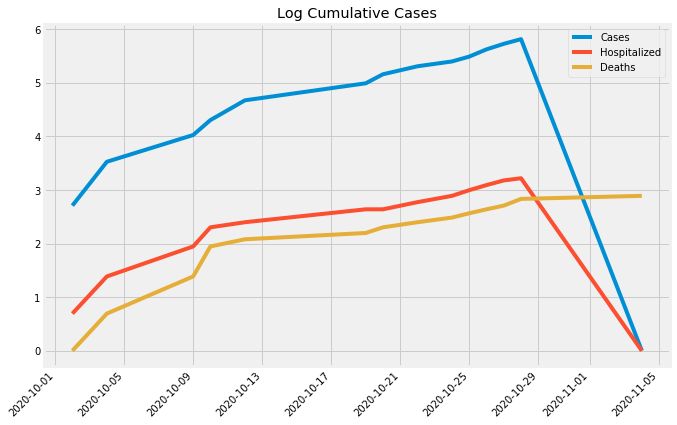

In [13]:
pd.set_option('use_inf_as_na', True)
dfLog = dfTotals.cumsum()

dfLog['Deaths'] = dfLog['Deaths'].apply(lambda x: np.log(x) if x > 0 else 0)
dfLog['Hospitalized'] = dfLog['Hospitalized'].apply(lambda x: np.log(x) if x > 0 else 0)
dfLog['Cases'] = dfLog['Cases'].apply(lambda x: np.log(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,7))
ax.plot(dfLog.index, dfLog["Cases"], label="Cases")
ax.plot(dfLog.index, dfLog["Hospitalized"], label="Hospitalized")
ax.plot(dfLog.index, dfLog["Deaths"], label="Deaths")
ax.legend()

plt.title("Log Cumulative Cases")
fig.autofmt_xdate(rotation=45)
        
t = ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

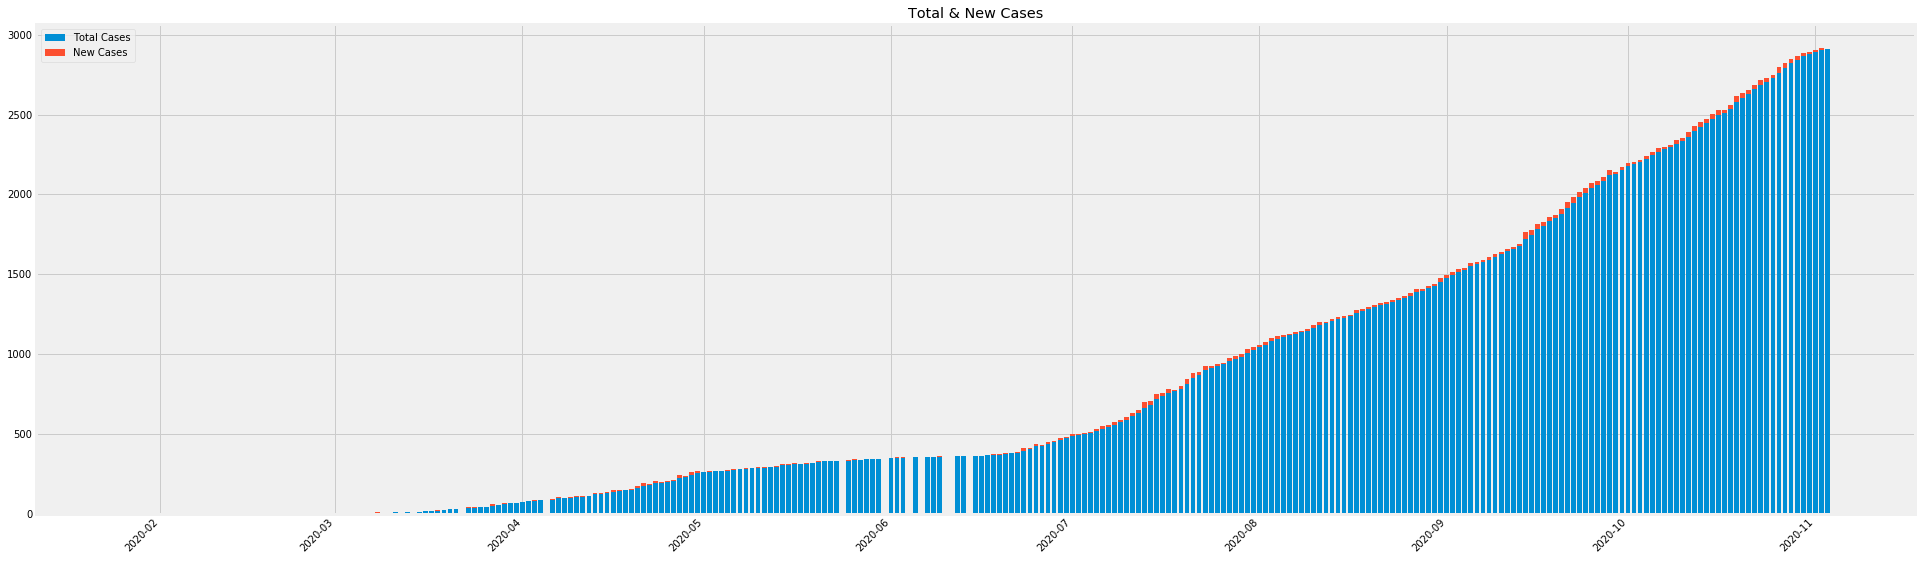

In [14]:
# Stacked Bar Chart of New/Current cases by date
d = pd.DataFrame()
d["New Cases"] = dfDate["Case Count"].sum()
d["New Hospitilizations"] = dfDate["Hospitalized Count"].sum()
d["New Deaths"] = dfDeathDate["Death Count"].sum()
totalCases = []
for row in d.itertuples():
    if len(totalCases) > 0:
        totalCases.append(row[1] + totalCases[len(totalCases)-1])
    else:
        totalCases.append(row[1])
        

d["Total Cases"] = totalCases

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(30,10))
ax.bar(d.index, d["Total Cases"], label='Total Cases')
ax.bar(d.index, d["New Cases"], bottom=d["Total Cases"], label='New Cases')

fig.autofmt_xdate(rotation=45)

plt.legend()
plt.title("Total & New Cases")
plt.show()

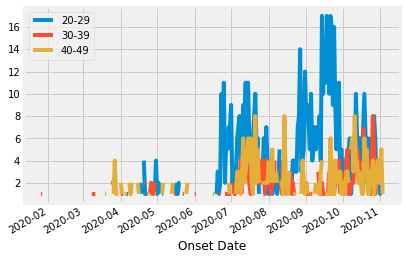

In [15]:
from datetime import datetime, timedelta

d = pd.DataFrame()
d["New Cases"] = dfAgeDate["Case Count"].sum()
# dfAgeDate
# d.reset_index(inplace=True)
d = d.unstack(level=0)
# d.plot()
# d["0-19"].plot()
#0-19  20-29  30-39  40-49  50-59  60-69  70-79    80+
# print(d["New Cases"])

# print(d["New Cases"]["0-19"].median())
# print(d["New Cases"]["20-29"].median())
# print(d["New Cases"]["30-39"].median())
# print(d["New Cases"]["40-49"].median())
# print(d["New Cases"]["50-59"].median())
# print(d["New Cases"]["60-69"].median())
# print(d["New Cases"]["70-79"].median())

d["New Cases"]["20-29"].plot()
d["New Cases"]["30-39"].plot()
d["New Cases"]["40-49"].plot()
# fig, ax = plt.subplots(2, 4, sharey=True, figsize=(20,20))
# d["New Cases"]["0-19"].plot(ax=ax[0][0], kind="bar")
# # d["New Cases"]["20-29"].plot(ax=ax[0][1], kind="bar")
# # d["New Cases"]["30-39"].plot(ax=ax[0][2], kind="bar")
# # d["New Cases"]["40-49"].plot(ax=ax[0][3], kind="bar")
# # d["New Cases"]["50-59"].plot(ax=ax[1][0], kind="bar")
# # d["New Cases"]["60-69"].plot(ax=ax[1][1], kind="bar")
# # d["New Cases"]["70-79"].plot(ax=ax[1][2], kind="bar")
# # d["New Cases"]["80+"].plot(ax=ax[1][3], kind="bar")

plt.legend()
# plt.show()


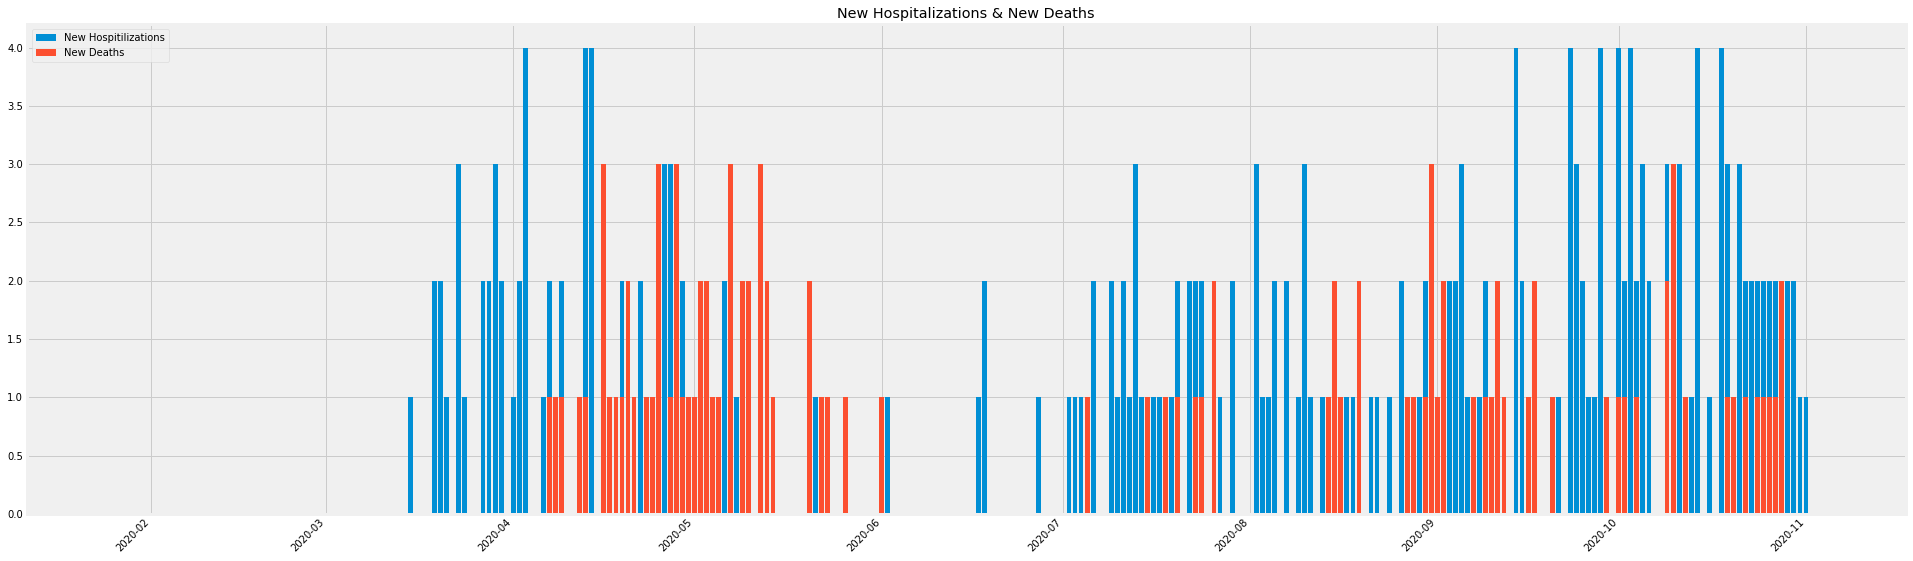

In [16]:
# Stacked Bar Chart of New/Current cases by date
# d = pd.DataFrame()
d["New Cases"] = dfDate["Case Count"].sum()
d["New Hospitilizations"] = dfDate["Hospitalized Count"].sum()
d["New Deaths"] = dfDeathDate["Death Count"].sum()
# totalCases = []
# for row in d.itertuples():
#     if len(totalCases) > 0:
#         totalCases.append(row[1] + totalCases[len(totalCases)-1])
#     else:
#         totalCases.append(row[1])

# d["Total Cases"] = totalCases

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(30,10))
# ax.bar(d.index, d["Total Cases"], label='Total Cases')
# ax.bar(d.index, d["New Cases"], label="New Cases")
ax.bar(d.index, d["New Hospitilizations"], label="New Hospitilizations")
ax.bar(d.index, d["New Deaths"], label="New Deaths")

fig.autofmt_xdate(rotation=45)

plt.legend()
plt.title("New Hospitalizations & New Deaths")
plt.show()

# Rolling Averages
The following section shows rolling averages, which a lot of folks are tracking these days.

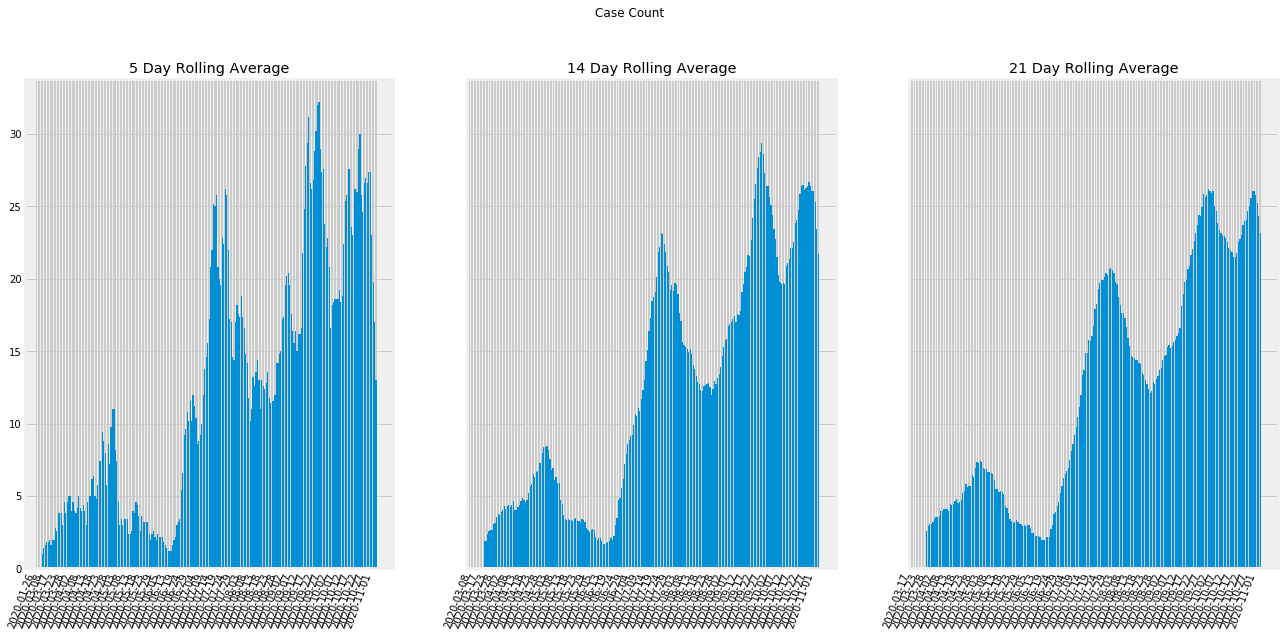

In [17]:
################## 5 Day Rolling Averages
h = pd.DataFrame(df.groupby("Onset Date")["Case Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Case Count"].rolling(5).mean()
h["Onset Date"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Onset Date"], h["Rolling"])
ax[0].set_title('5 Day Rolling Average')

################## 14 Day Rolling Averages
h = pd.DataFrame(df.groupby("Onset Date")["Case Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Case Count"].rolling(14).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Onset Date"], h["Rolling"])
ax[1].set_title('14 Day Rolling Average')

fig.suptitle("Case Count")

################## 21 Day Rolling Averages
h = pd.DataFrame(df.groupby("Onset Date")["Case Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Case Count"].rolling(21).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[2].bar(h["Onset Date"], h["Rolling"])
ax[2].set_title('21 Day Rolling Average')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 5 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])

fig.suptitle("Case Count")


plt.show()

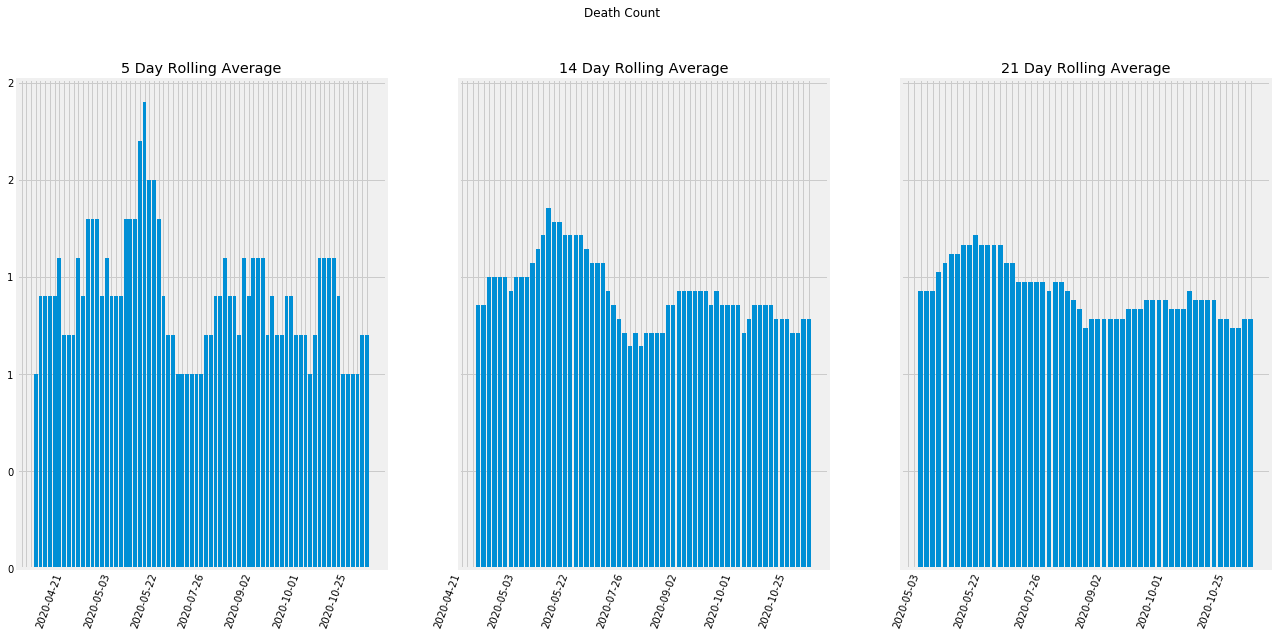

In [18]:
# 5 Day Rolling Averages
h = pd.DataFrame(df.groupby("Date Of Death")["Death Count"].sum())
h.sort_values(by="Date Of Death")

h["Rolling"] = h["Death Count"].rolling(5).mean()
h["Date Of Death"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Date Of Death"], h["Rolling"])
ax[0].set_title('5 Day Rolling Average')

h["Rolling"] = h["Death Count"].rolling(14).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Date Of Death"], h["Rolling"])
ax[1].set_title('14 Day Rolling Average')

################## 21 Day Rolling Averages
h = pd.DataFrame(df.groupby("Date Of Death")["Death Count"].sum())
h.sort_values(by="Date Of Death")

h["Rolling"] = h["Death Count"].rolling(21).mean()
h["Date Of Death"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[2].bar(h["Date Of Death"], h["Rolling"])
ax[2].set_title('21 Day Rolling Average')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 10 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
    
fig.suptitle("Death Count")

plt.show()

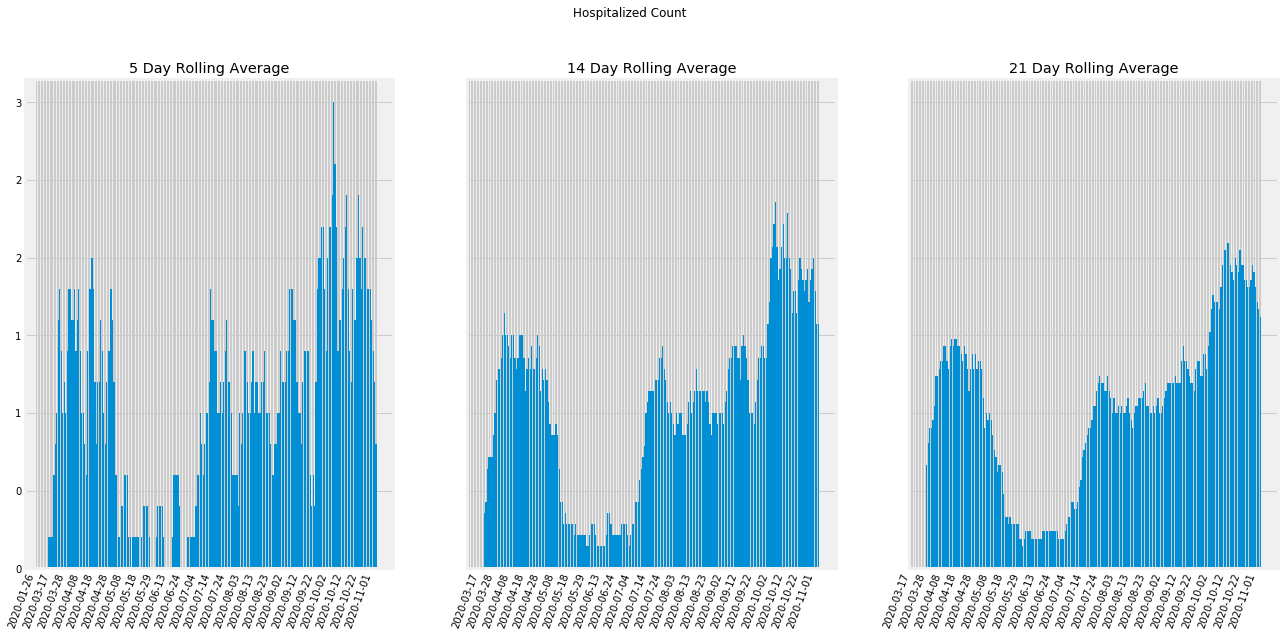

In [19]:
# 5 Day Rolling Averages
h = pd.DataFrame(df.groupby("Onset Date")["Hospitalized Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Hospitalized Count"].rolling(5).mean()
h["Onset Date"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Onset Date"], h["Rolling"])
ax[0].set_title('5 Day Rolling Average')

h["Rolling"] = h["Hospitalized Count"].rolling(14).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Onset Date"], h["Rolling"])
ax[1].set_title('14 Day Rolling Average')

################## 21 Day Rolling Averages
h = pd.DataFrame(df.groupby("Onset Date")["Hospitalized Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Hospitalized Count"].rolling(21).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[2].bar(h["Onset Date"], h["Rolling"])
ax[2].set_title('21 Day Rolling Average')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 10 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
fig.suptitle("Hospitalized Count")

plt.show()

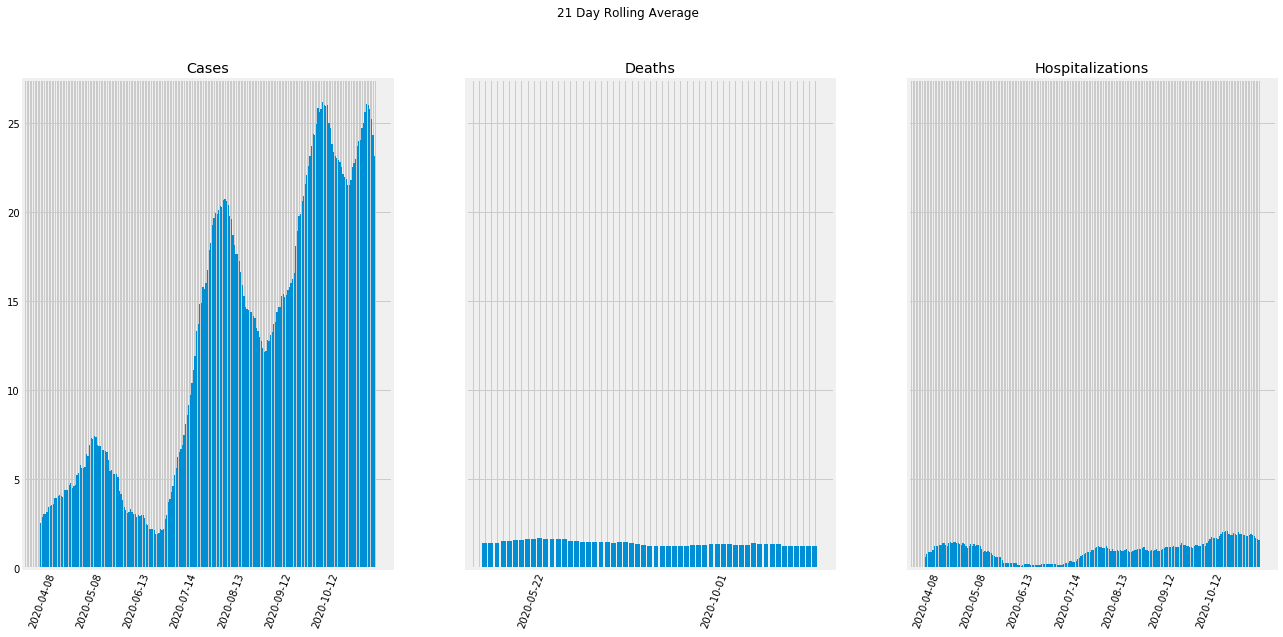

In [20]:
rollingAvg = 21

################## Cases
h = pd.DataFrame(df.groupby("Onset Date")["Case Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Case Count"].rolling(rollingAvg).mean()
h["Onset Date"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Onset Date"], h["Rolling"])
ax[0].set_title('Cases')

# fig.autofmt_xdate(rotation=70)
# for a in ax:
#     for index, label in enumerate(a.xaxis.get_ticklabels()):
#         if index % 5 != 0:
#             label.set_visible(False)
#     t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])


################# Deaths
h = pd.DataFrame(df.groupby("Date Of Death")["Death Count"].sum())
h.sort_values(by="Date Of Death")

h["Rolling"] = h["Death Count"].rolling(rollingAvg).mean()
h["Date Of Death"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Date Of Death"], h["Rolling"])
ax[1].set_title('Deaths')

h = pd.DataFrame(df.groupby("Onset Date")["Hospitalized Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Hospitalized Count"].rolling(rollingAvg).mean()
h["Onset Date"] = h.index.astype(str)

ax[2].bar(h["Onset Date"], h["Rolling"])
ax[2].set_title('Hospitalizations')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 30 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
fig.suptitle("21 Day Rolling Average")


plt.show()

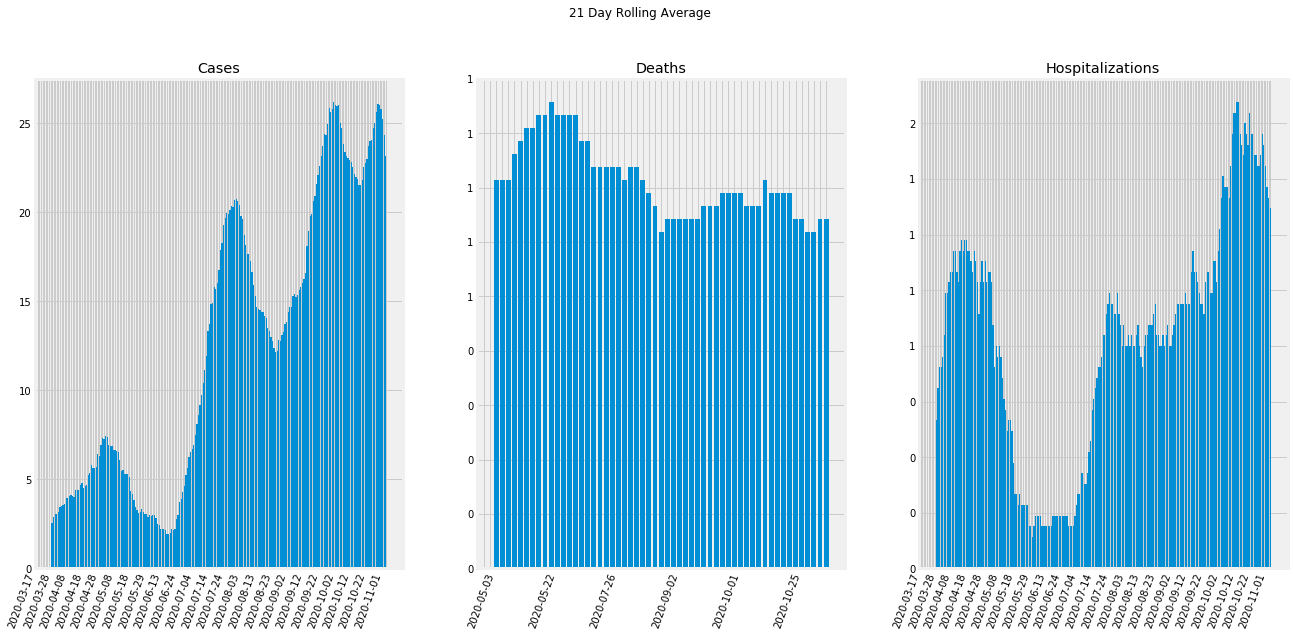

In [21]:
rollingAvg = 21

################## Cases
h = pd.DataFrame(df.groupby("Onset Date")["Case Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Case Count"].rolling(rollingAvg).mean()
h["Onset Date"] = h.index.astype(str)

fig, ax = plt.subplots(1, 3, sharey=False, figsize=(20,10))

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[0].bar(h["Onset Date"], h["Rolling"])
ax[0].set_title('Cases')

# fig.autofmt_xdate(rotation=70)
# for a in ax:
#     for index, label in enumerate(a.xaxis.get_ticklabels()):
#         if index % 5 != 0:
#             label.set_visible(False)
#     t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])


################# Deaths
h = pd.DataFrame(df.groupby("Date Of Death")["Death Count"].sum())
h.sort_values(by="Date Of Death")

h["Rolling"] = h["Death Count"].rolling(rollingAvg).mean()
h["Date Of Death"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[1].bar(h["Date Of Death"], h["Rolling"])
ax[1].set_title('Deaths')

# fig.autofmt_xdate(rotation=70)
# for a in ax:
#     for index, label in enumerate(a.xaxis.get_ticklabels()):
#         if index % 10 != 0:
#             label.set_visible(False)
#     t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
    
# fig.suptitle("Death Count")

h = pd.DataFrame(df.groupby("Onset Date")["Hospitalized Count"].sum())
h.sort_values(by="Onset Date")

h["Rolling"] = h["Hospitalized Count"].rolling(rollingAvg).mean()
h["Onset Date"] = h.index.astype(str)

# ax = sns.catplot(x="Onset Date", y="Rolling", data=h, kind="bar", aspect=25/15)
ax[2].bar(h["Onset Date"], h["Rolling"])
ax[2].set_title('Hospitalizations')

fig.autofmt_xdate(rotation=70)
for a in ax:
    for index, label in enumerate(a.xaxis.get_ticklabels()):
        if index % 10 != 0:
            label.set_visible(False)
    t = a.set_yticklabels(['{:,}'.format(int(x)) for x in a.get_yticks().tolist()])
fig.suptitle("21 Day Rolling Average")


plt.show()

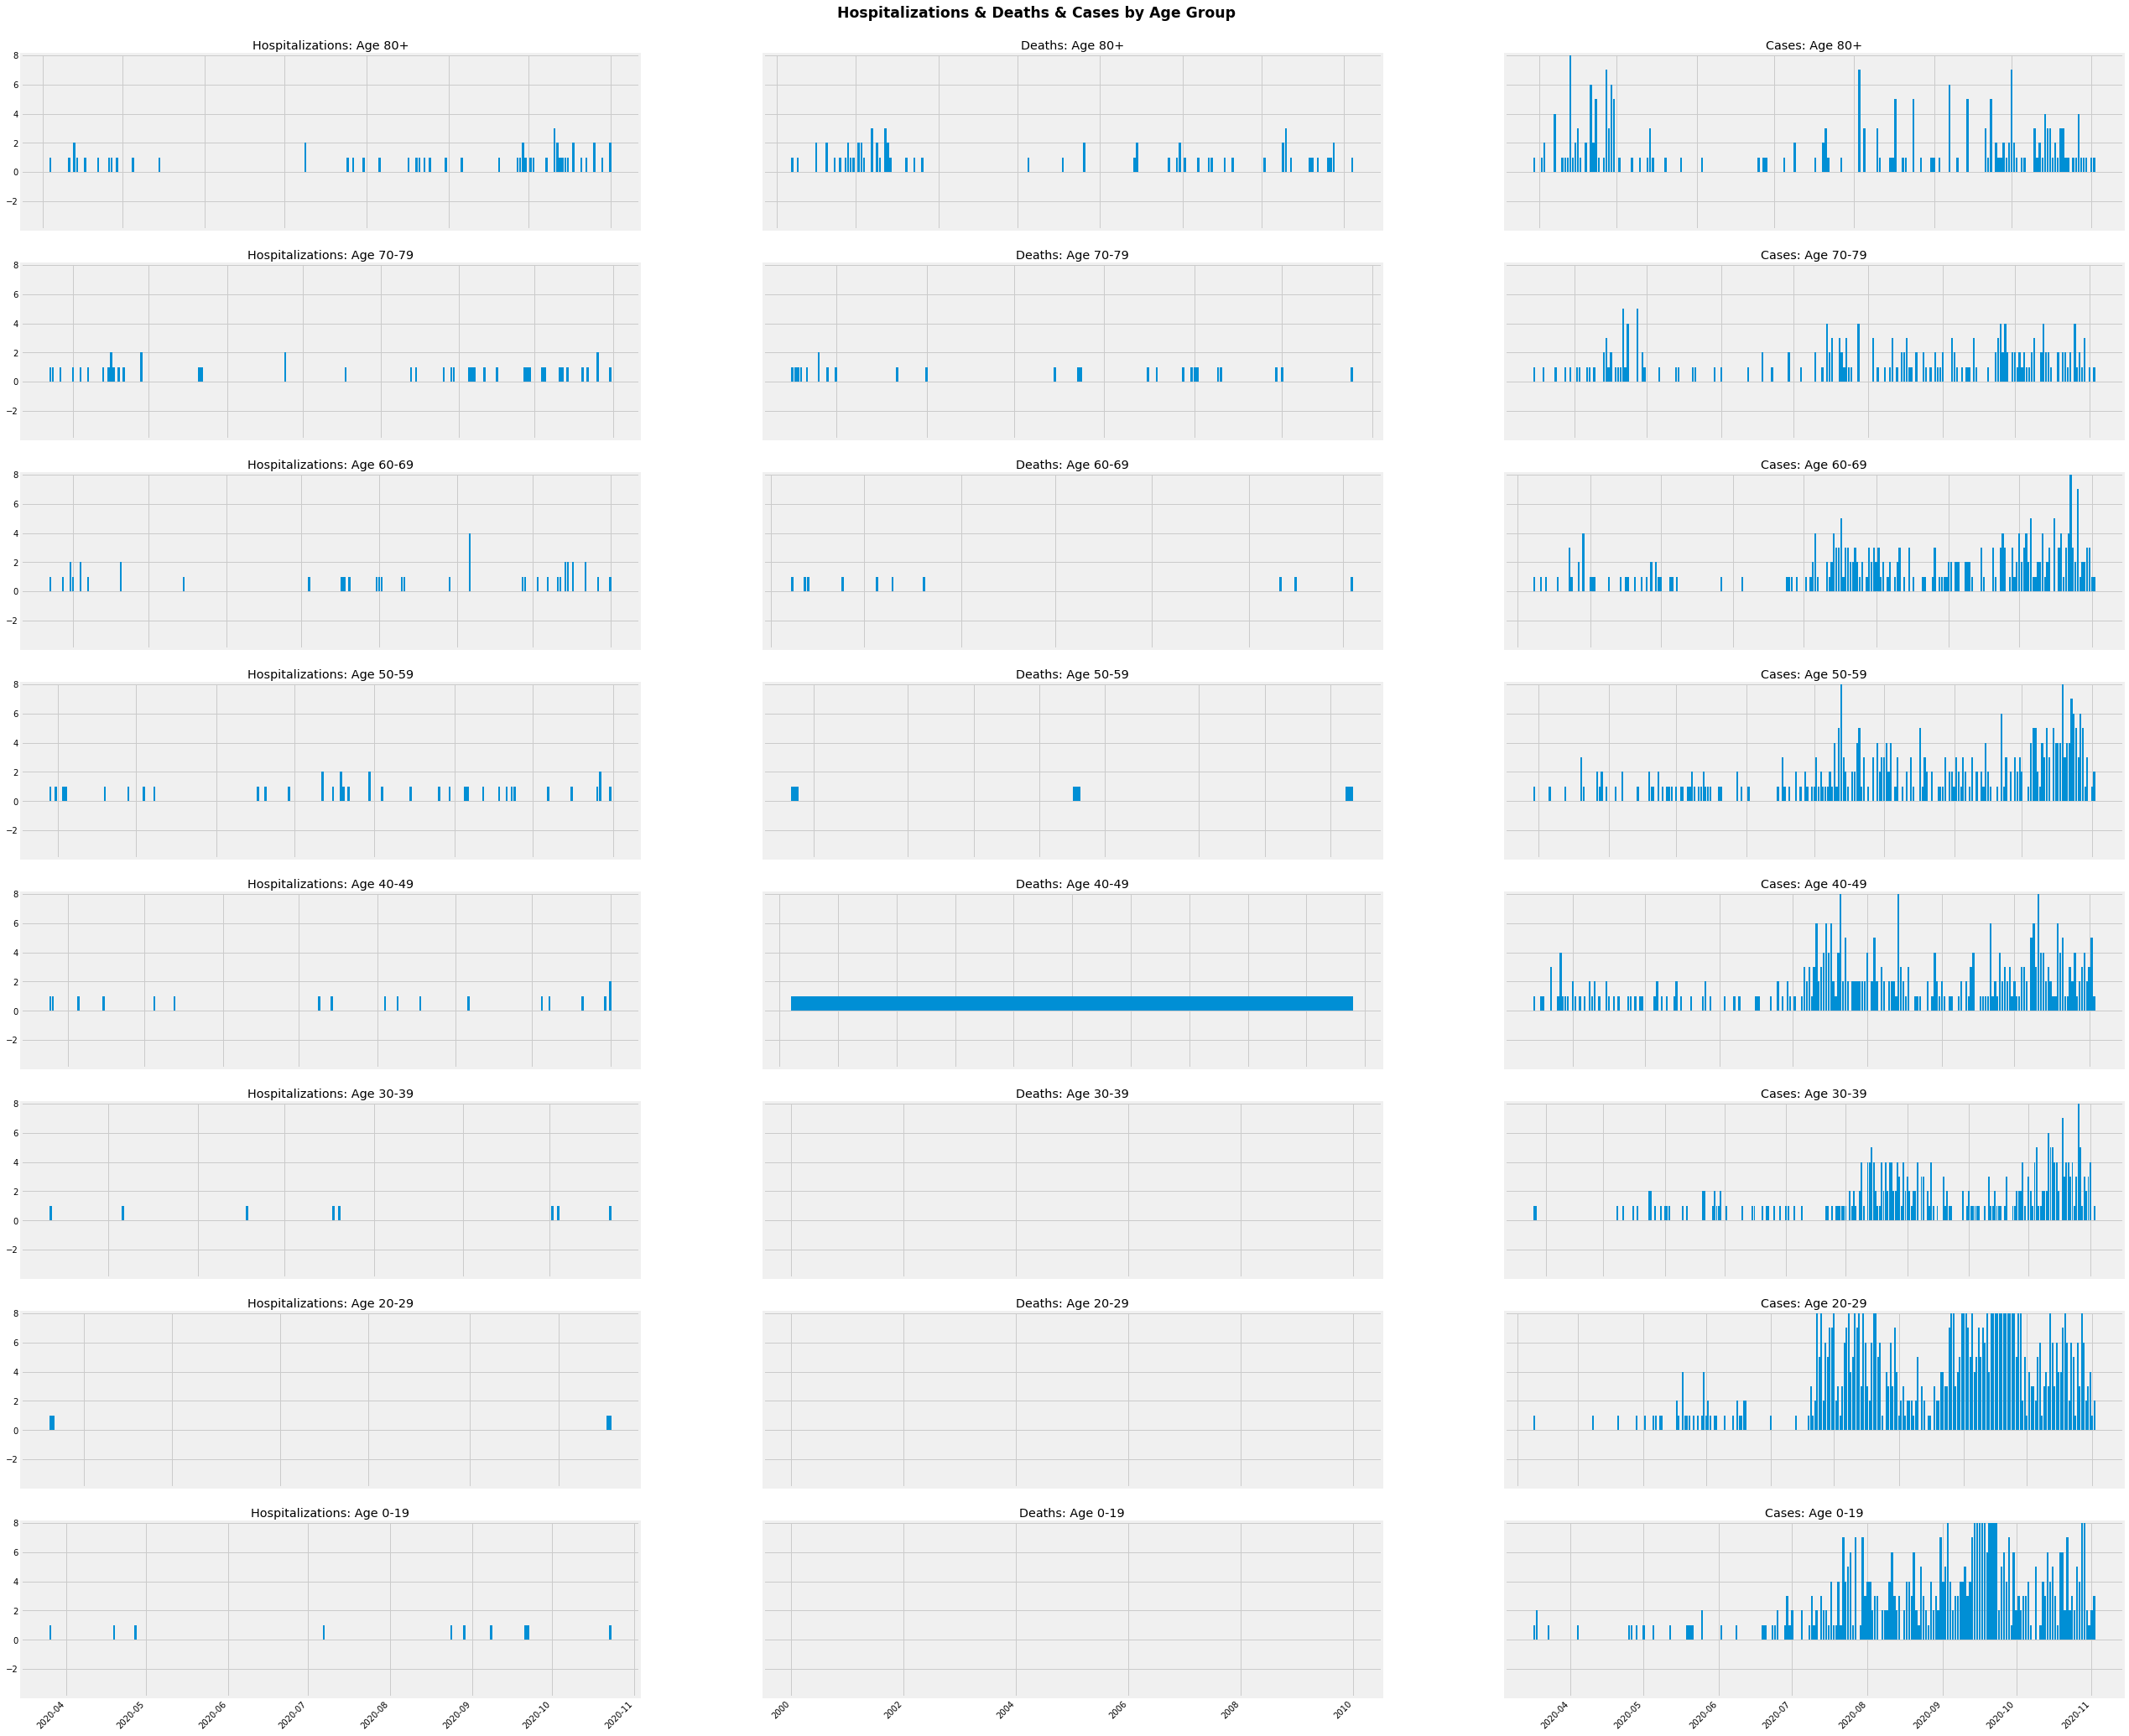

In [22]:
# By Date
localDf = {}

dfHospAgeDate = df.groupby(["Age Range","Admission Date"])
# Admission Date
dfHospAgeDate = dfHospAgeDate.sum().reset_index()

fig, ax = plt.subplots(8, 3, sharey=True, figsize=(40,40))


localDf["80+"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "80+") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[0][0].bar(localDf["80+"]["Admission Date"], localDf["80+"]["Hospitalized Count"])
ax[0][0].set_title("Hospitalizations: Age 80+")

localDf["70-79"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "70-79") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[1][0].bar(localDf["70-79"]["Admission Date"], localDf["70-79"]["Hospitalized Count"])
ax[1][0].set_title("Hospitalizations: Age 70-79")

localDf["60-69"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "60-69") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[2][0].bar(localDf["60-69"]["Admission Date"], localDf["60-69"]["Hospitalized Count"])
ax[2][0].set_title("Hospitalizations: Age 60-69")

localDf["50-59"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "50-59") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[3][0].bar(localDf["50-59"]["Admission Date"], localDf["50-59"]["Hospitalized Count"])
ax[3][0].set_title("Hospitalizations: Age 50-59")

localDf["40-49"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "40-49") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[4][0].bar(localDf["40-49"]["Admission Date"], localDf["40-49"]["Hospitalized Count"])
ax[4][0].set_title("Hospitalizations: Age 40-49")

localDf["30-39"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "30-39") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[5][0].bar(localDf["30-39"]["Admission Date"], localDf["30-39"]["Hospitalized Count"])
ax[5][0].set_title("Hospitalizations: Age 30-39")

localDf["20-29"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "20-29") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[7][0].bar(localDf["20-29"]["Admission Date"], localDf["20-29"]["Hospitalized Count"])
ax[6][0].set_title("Hospitalizations: Age 20-29")

localDf["0-19"] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == "0-19") & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[6][0].bar(localDf["0-19"]["Admission Date"], localDf["0-19"]["Hospitalized Count"])
ax[7][0].set_title("Hospitalizations: Age 0-19")

# Deaths
dfDeathAgeDate = df.groupby(["Age Range","Date Of Death"])
dfDeathAgeDate = dfDeathAgeDate.sum().reset_index()

localDeathDf = {}
localDeathDf["80+"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "80+") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[0][1].bar(localDeathDf["80+"]["Date Of Death"], localDeathDf["80+"]["Death Count"])
ax[0][1].set_title("Deaths: Age 80+")

localDeathDf["70-79"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "70-79") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[1][1].bar(localDeathDf["70-79"]["Date Of Death"], localDeathDf["70-79"]["Death Count"])
ax[1][1].set_title("Deaths: Age 70-79")

localDeathDf["60-69"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "60-69") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[2][1].bar(localDeathDf["60-69"]["Date Of Death"], localDeathDf["60-69"]["Death Count"])
ax[2][1].set_title("Deaths: Age 60-69")

localDeathDf["50-59"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "50-59") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[3][1].bar(localDeathDf["50-59"]["Date Of Death"], localDeathDf["50-59"]["Death Count"])
ax[3][1].set_title("Deaths: Age 50-59")

localDeathDf["40-49"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "40-49") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[4][1].bar(localDeathDf["40-49"]["Date Of Death"], localDeathDf["40-49"]["Death Count"])
ax[4][1].set_title("Deaths: Age 40-49")

localDeathDf["30-39"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "30-39") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[5][1].bar(localDeathDf["30-39"]["Date Of Death"], localDeathDf["30-39"]["Death Count"])
ax[5][1].set_title("Deaths: Age 30-39")

localDeathDf["20-29"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "20-29") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[6][1].bar(localDeathDf["20-29"]["Date Of Death"], localDeathDf["20-29"]["Death Count"])
ax[6][1].set_title("Deaths: Age 20-29")

localDeathDf["0-19"] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == "0-19") & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[7][1].bar(localDeathDf["0-19"]["Date Of Death"], localDeathDf["0-19"]["Death Count"])
ax[7][1].set_title("Deaths: Age 0-19")

# Cases
dfCaseAgeDate = df.groupby(["Age Range","Onset Date"])
dfCaseAgeDate = dfCaseAgeDate.sum().reset_index()

localCaseDf = {}
localCaseDf["80+"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "80+") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[0][2].bar(localCaseDf["80+"]["Onset Date"], localCaseDf["80+"]["Case Count"])
ax[0][2].set_title("Cases: Age 80+")

localCaseDf["70-79"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "70-79") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[1][2].bar(localCaseDf["70-79"]["Onset Date"], localCaseDf["70-79"]["Case Count"])
ax[1][2].set_title("Cases: Age 70-79")

localCaseDf["60-69"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "60-69") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[2][2].bar(localCaseDf["60-69"]["Onset Date"], localCaseDf["60-69"]["Case Count"])
ax[2][2].set_title("Cases: Age 60-69")

localCaseDf["50-59"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "50-59") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[3][2].bar(localCaseDf["50-59"]["Onset Date"], localCaseDf["50-59"]["Case Count"])
ax[3][2].set_title("Cases: Age 50-59")

localCaseDf["40-49"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "40-49") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[4][2].bar(localCaseDf["40-49"]["Onset Date"], localCaseDf["40-49"]["Case Count"])
ax[4][2].set_title("Cases: Age 40-49")

localCaseDf["30-39"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "30-39") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[5][2].bar(localCaseDf["30-39"]["Onset Date"], localCaseDf["30-39"]["Case Count"])
ax[5][2].set_title("Cases: Age 30-39")

localCaseDf["20-29"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "20-29") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[6][2].bar(localCaseDf["20-29"]["Onset Date"], localCaseDf["20-29"]["Case Count"])
ax[6][2].set_title("Cases: Age 20-29")

localCaseDf["0-19"] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == "0-19") & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[7][2].bar(localCaseDf["0-19"]["Onset Date"], localCaseDf["0-19"]["Case Count"])
ax[7][2].set_title("Cases: Age 0-19")

fig.suptitle("Hospitalizations & Deaths & Cases by Age Group", y=.9, fontsize="xx-large", fontweight="bold")
fig.autofmt_xdate(rotation=45)
plt.show()

fig.savefig("Hosp_Case_Death.png")


IndexError: list index out of range

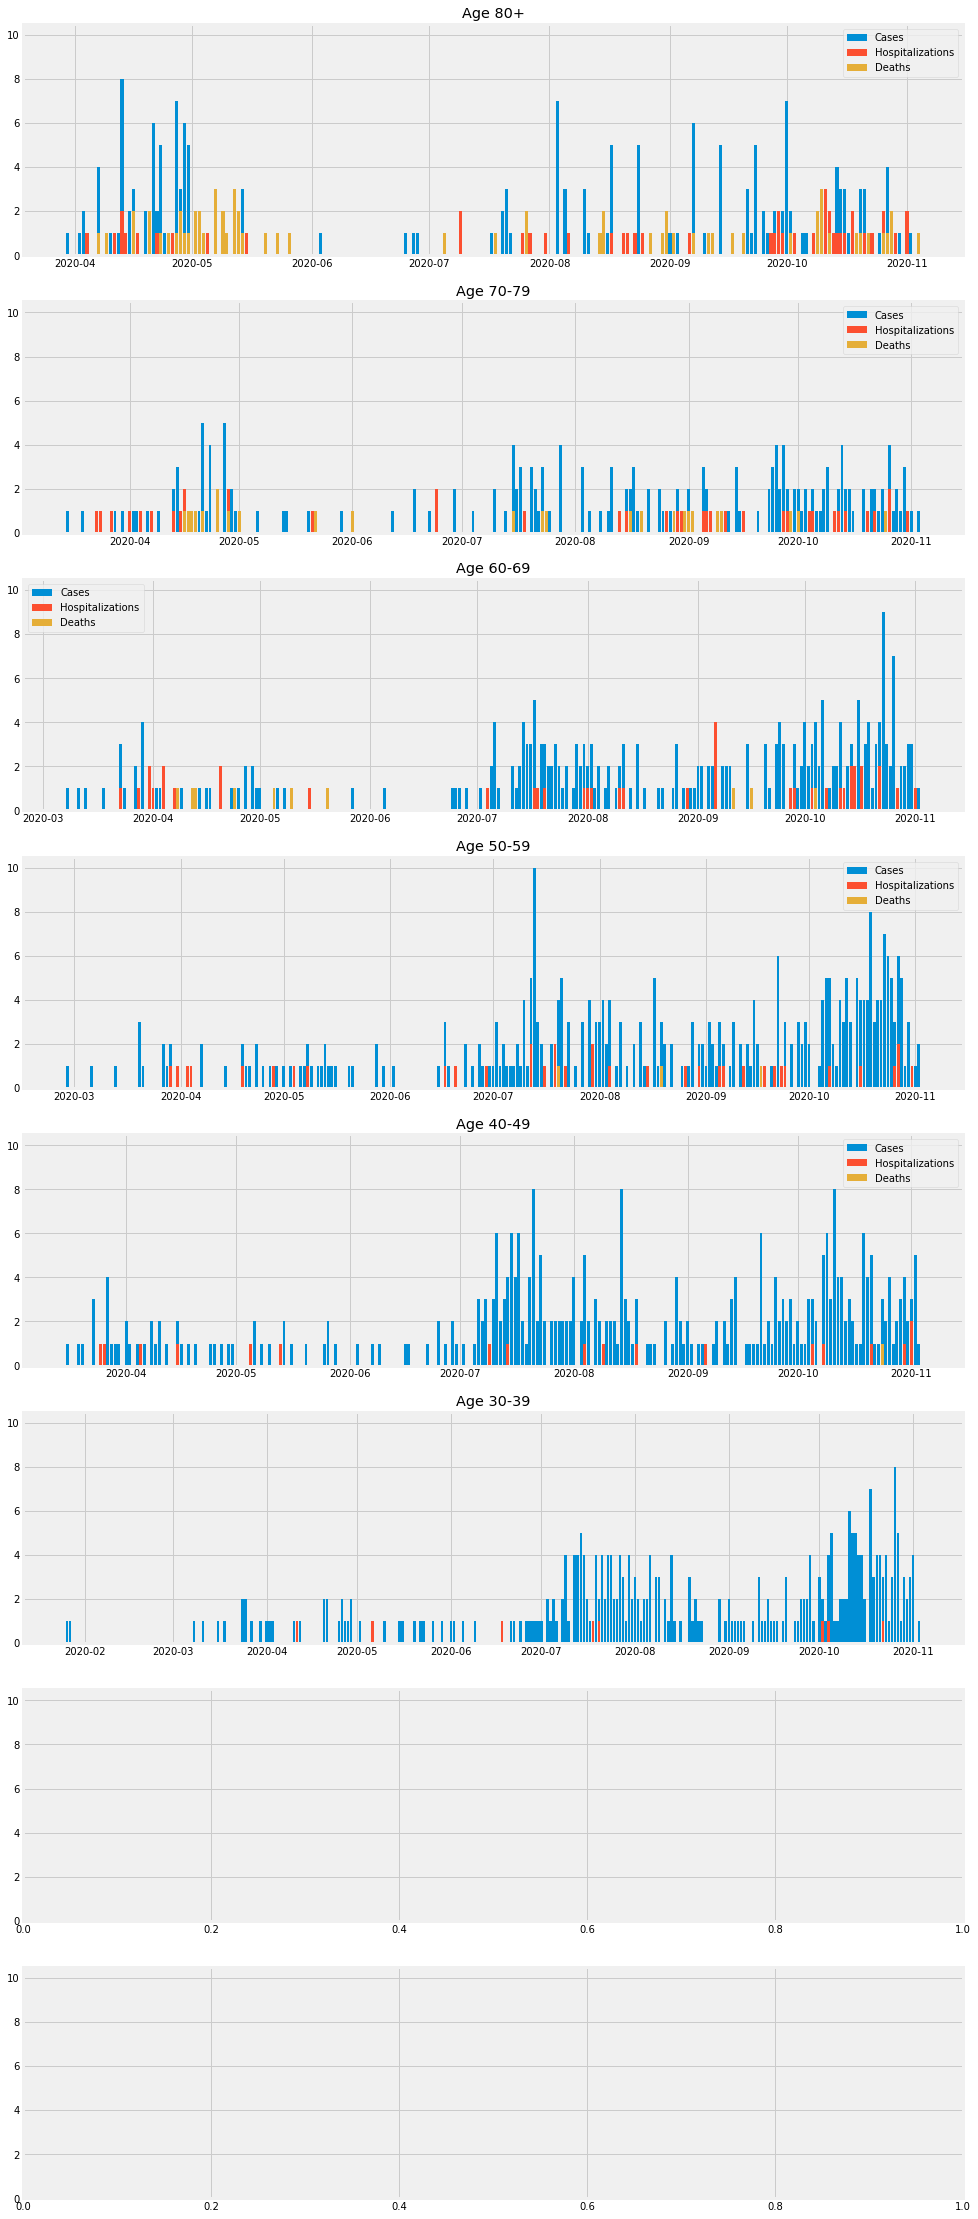

In [23]:
# By Date
localDf = {}
localDeathDf = {}
localCaseDf = {}

# Hospitalizations
dfHospAgeDate = df.groupby(["Age Range","Admission Date"])
dfHospAgeDate = dfHospAgeDate.sum().reset_index()

# Deaths
dfDeathAgeDate = df.groupby(["Age Range","Date Of Death"])
dfDeathAgeDate = dfDeathAgeDate.sum().reset_index()

# Cases
dfCaseAgeDate = df.groupby(["Age Range","Onset Date"])
dfCaseAgeDate = dfCaseAgeDate.sum().reset_index()


fig, ax = plt.subplots(8, 1, sharey=True, figsize=(15,40))


ageRange = "80+"
localAxis = 0
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "70-79"
localAxis = 1
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "60-69"
localAxis = 2
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "50-59"
localAxis = 3
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "40-49"
localAxis = 4
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "30-39"
localAxis = 5
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "20-29"
localAxis = 6
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()

ageRange = "0-19"
localAxis = 7
localCaseDf[ageRange] = dfCaseAgeDate[(dfCaseAgeDate["Age Range"] == ageRange) & (dfCaseAgeDate["Onset Date"] != "2020/03/01")].sort_values("Onset Date")
ax[localAxis].bar(localCaseDf[ageRange]["Onset Date"], localCaseDf[ageRange]["Case Count"], label="Cases")

localDf[ageRange] = dfHospAgeDate[(dfHospAgeDate["Age Range"] == ageRange) & (dfHospAgeDate["Admission Date"] != "2020/03/01")].sort_values("Admission Date")
ax[localAxis].bar(localDf[ageRange]["Admission Date"], localDf[ageRange]["Hospitalized Count"], label="Hospitalizations")

localDeathDf[ageRange] = dfDeathAgeDate[(dfDeathAgeDate["Age Range"] == ageRange) & (dfDeathAgeDate["Date Of Death"] != "2020/03/01")].sort_values("Date Of Death")
ax[localAxis].bar(localDeathDf[ageRange]["Date Of Death"], localDeathDf[ageRange]["Death Count"], label="Deaths")
ax[localAxis].set_title("Age " + ageRange)
ax[localAxis].legend()


fig.suptitle("Hospitalizations & Deaths & Cases by Age Group", y=.9, fontsize="xx-large", fontweight="bold")
fig.autofmt_xdate(rotation=45)
plt.show()

fig.savefig("Hosp_Case_Death_2.png")


In [ ]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)


fig, ax = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(15,20))

ax[0].pie(dfAgeTotals["Deaths"], labels=dfAgeTotals.index, labeldistance=None, autopct='%1.1f%%')
ax[0].set_title("Deaths")
ax[0].legend()

ax[1].pie(dfAgeTotals["Hospitalized"], labels=dfAgeTotals.index, labeldistance=None, autopct='%1.1f%%')
ax[1].set_title("Hospitalized")
ax[1].legend()

ax[2].pie(dfAgeTotals["Cases"], labels=dfAgeTotals.index, labeldistance=None, autopct='%1.1f%%')
ax[2].set_title("Cases")
ax[2].legend()

plt.show()

In [ ]:
dfAgeTotals